Some references:
1. https://www.datasciencecentral.com/profiles/blogs/some-more-social-network-analysis-with-python-centrality-pagerank

2. http://blog.samuelmh.com/2015/02/pagerank-sparse-matrices-python-ipython.html

3. https://github.com/MaxPoon/coursera-Applied-Data-Science-with-Python/tree/master/Applied-Social-Network-Analysis-In-Python/week4

## Randomly Generated Graphs
We will first generate input graphs using three types of graphs:
- Preferential Attachment
- Small World with low probability of rewiring
- Small World with high probability of rewiring

### Preferential Attachment Model
**1. Degree Distributions**

The degree distribution of a graph is the probability distribution of the degrees over the entire network.

https://github.com/MaxPoon/coursera-Applied-Data-Science-with-Python/blob/master/Applied-Social-Network-Analysis-In-Python/week4/4.1_Preferential-Attachment-Model.pdf

**2. Preferential Attachment Model**
- Start with two nodes connected by an edge
- At each time step, add a new node with an edge connecting it to an existing node
- Choose the node to connect to at random with probability proportional to each node's degree
- The probability of connecting to a node *u* of degree *$k_u$* is $k_u/\sum_j k_j$

做presentation时记得每步说明

As the number of nodes increases, the preferential attachment model produces networks with degree distributions similar to real networks.

**3. Preferential Attachment Model in NetworkX**

barabasi_albert_graph(n, m) returns a network with n nodes. Each new node attaches to m existing nodes according to the Preferential Attachment model.

In [9]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

To illustrate this, we create a graph with 1000000 nodes starting from 1 node.

In [12]:
G = nx.barabasi_albert_graph(1000000, 1)
degrees = G.degree()
degree_values = sorted(set(degrees.values()))
histogram = [list(degrees.values()).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]

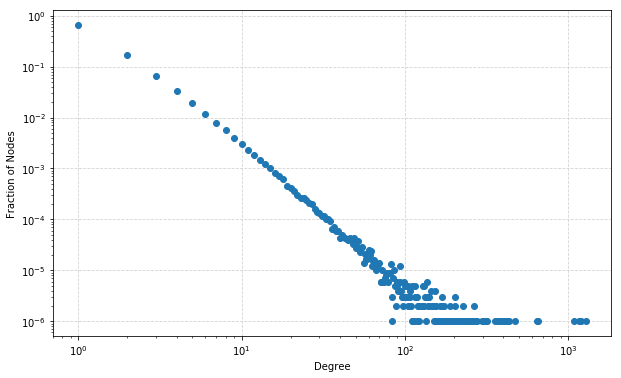

In [13]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(degree_values, histogram, 'o')
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.xscale('log')
plt.yscale('log')
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()